# MODULATION SPECTRUM

### Loading all the required libraries.

In [ ]:
!pip3 install pysptk

     |████████████████████████████████| 410 kB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pysptk: filename=pysptk-0.1.20-cp37-cp37m-linux_x86_64.whl size=929932 sha256=d39ea25de2f3ac76aa7d66b39c8ab8dda9e8ee3de57d343857fe3561161b72f5
  Stored in directory: /root/.cache/pip/wheels/dd/37/3f/7583b00bf73e73650aad5d268ee46b95dbd6dffbd237e1bf58
Successfully built pysptk


In [ ]:
!pip3 install pyworld

     |████████████████████████████████| 212 kB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyworld: filename=pyworld-0.3.0-cp37-cp37m-linux_x86_64.whl size=609505 sha256=e48b54ae8e739621fdfd9d88bb1ca10d28dd783d637b56e8970f2827073a1ddb
  Stored in directory: /root/.cache/pip/wheels/e7/7c/11/c775fffa0e1e7b05a6604b4323408a77f80fb4ab304d96b5c6
Successfully built pyworld


In [ ]:
import torch
from scipy.io import wavfile
import pysptk
from pysptk.synthesis import Synthesizer, MLSADF
import pyworld
from os.path import join, basename
import librosa
import librosa.display
import IPython
from IPython.display import Audio
import glob
import os
import numpy as np
from os.path import join, basename
import collections

# Loading Data 
* Upload your data in your google drive 
* Run the cell below , and your drive will be accessible from this notebook. This will ask for your permission.
* After granting the permission , you can access any folder or file in your drive from this notebook environment.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def getpaths():  
  """
  This function takes input from the user , i.e. , the number of datasets and the path of the datasets
  
  """
  print("Enter No. of Datasets :")
  n=int(input())
  paths=[]
  for i in range(n):
    if i ==0:
      paths.append(input("Enter Original path : "))
    else:
      paths.append(input(f"Enter path{i} : "))
  return paths

### Enter the number of datasets and the paths :
* Enter a numrical value , like 2/4 with respect to the number of datasets you want to visualize.
* Enter the path of the original data first.
* Then you can put the path of the other datasets. 

### Note : The datasets should contain same number of wav files with the same name of each wav file.

In [ ]:
paths=getpaths()

Enter No. of Datasets :
2
Enter Original path : /content/drive/MyDrive/Male-to-Male-Voice/SM1
Enter path1 : /content/drive/MyDrive/Male-to-Male-Voice/converted_SM2_Speech_in_SM1_Voice


In [ ]:
from tqdm import tnrange
fs = 16000
frame_period=5.0
hop_length = int(fs * (frame_period * 0.001))
ms_fftlen = 4096
modfs = fs / hop_length
ms_freq = np.arange(ms_fftlen//2 + 1)/ms_fftlen * modfs
ms_freq

array([0.00000000e+00, 4.88281250e-02, 9.76562500e-02, ...,
       9.99023438e+01, 9.99511719e+01, 1.00000000e+02])

### Funtion to compute the static feature - 
* Takes wav file path as input.
* Returns the Global variance as output.

In [ ]:
def compute_static_features(path):
    fs, x = wavfile.read(path)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=5.0)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)
    alpha = pysptk.util.mcepalpha(fs)
    mc = pysptk.sp2mc(spectrogram, order=24, alpha=alpha)
    c0, mc = mc[:, 0], mc[:, 1:]
    return mc

In [ ]:
def modspec(x, n=4096, norm=None, return_phase=False):
    
    # DFT against time axis
    s_complex = np.fft.rfft(x, n=n, axis=0, norm=norm)
    assert s_complex.shape[0] == n // 2 + 1
    R, im = s_complex.real, s_complex.imag
    ms = R * R + im * im

    # TODO: this is ugly...
    if return_phase:
        return ms, np.exp(1.0j * np.angle(s_complex))
    else:
        return ms

In [ ]:
def mean_modspec(files):
    mss = []
    # for idx in tnrange(len(files)):
    #     f = files[idx] 
    mgc = compute_static_features(files)
        #print(mgc)
        #b=log(modspec(mgc, n=ms_fftlen))
        #print(b)
        #print(np.any(b<=0))

    
        #print(b)
    ms = np.log(modspec(mgc, n=ms_fftlen))
    mss.append(ms)
    return np.mean(np.array(mss), axis=(0,))

In [ ]:
print(paths)

['/content/drive/MyDrive/Male-to-Male-Voice/SM1', '/content/drive/MyDrive/Male-to-Male-Voice/converted_SM2_Speech_in_SM1_Voice']


### Function to calculate RMSE value 

In [ ]:
def calc_rmse(x,y):
    min=np.sqrt(((x - y) ** 2).mean())
    return min

### Function to calculate Modulation Spectrum:
* Takes the paths as input.
* Takes user input for Labels  for the plot, with respect to each dataset.
* Takes user input for the dimensions that will be visualized.
* Calculates the Modulation Spectrum of all the datasets.

In [ ]:
from numpy.core.fromnumeric import shape
import collections
def get_mc(paths):
    print("Enter the Labels : ")
    labels=[]
    n=len(paths)
    for i in range(n):
      if i ==0:
        labels.append(input("Enter label for Original path : "))
      else:
        labels.append(input(f"Enter label for path_{i} : "))

    print("Enter No. of Dimensions to visualize :")
    nd=int(input())
    dims=[]
    indx=[]
    for i in range(nd):
      dim=int(input(f"Enter Dimension-No. {i+1} ( max. - 24 ): "))
      dims.append(dim-1)


    mcep_dict = collections.defaultdict(list)
    file_paths={}
    for i in range(n):
      path=glob.glob(paths[i]+'/*')
      # print(len(path))
      path=sorted(path)
      # print(path)
      file_paths[f'path_{i+1}'] = path
      for wav in file_paths[f'path_{i+1}']:
        # print(wav)
        mc=mean_modspec(wav)
        mcep_dict[f'path_{i+1}'].append(mc)

    
    for d in dims:
      mini=[]
      for k in range(len(mcep_dict['path_1'])):
        j=1
        min_dif=0
        while (j+1)<=n:
          min_dif+=(calc_rmse(mcep_dict['path_1'][k][:,dim],mcep_dict[f'path_{j+1}'][k][:,dim]))
          j+=1
      
        mini.append(min_dif)
      indx.append(mini.index(min(mini)))

    #(gv_dict[0][1]))

    return mcep_dict,labels,indx,dims

In [ ]:
lists,labels,ind,dims=get_mc(paths)

In [ ]:
%pylab inline
rcParams["figure.figsize"] = (16,5)

import sys
sys.path.insert(0, "..")

Populating the interactive namespace from numpy and matplotlib


### Function to visualize Modulation Spectrum:
* Takes the Modulation spectrum values , labels , index for best value , modulation spectrum frequencies and dimensions as input.
* Compare the values and shows the best plot from the dataset for the given dimensions.

In [ ]:
from numpy.core.numeric import array_equiv
def vis(lists,labels,ind,a,dims):  
  for d in range(len(dims)):
    j=0
    fig, ax = plt.subplots(figsize=(24,8))
    for i in lists.keys():
      arr=lists[i][ind[d]][:,dims[d]]
      values=range(len(a))
      #plt.plot(gv_dict[i][1], marker=marker[j] ,linewidth=2, label=labels[j])
      ax.plot(a,arr, linewidth=2, label=labels[j])
      ax.set_xticks(a,values)
    
      ax.set_xticks(a[::50])
      xscale("log")
      xlabel("Hz", fontsize=16)
      plt.legend(loc='center left', prop={'size': 16}, bbox_to_anchor=(1, 1))
      ax.set_xticklabels(values[::400])
      plt.xlabel("Modulation frequency index")
      plt.ylabel("MS[dB]",fontsize=16)
      title(f"Modulation Spectrum for dimension - {dims[d]+1} :",fontsize=18)
      j+=1
    plt.savefig(f'MCEP_Trajectory for Dimension{int(dims[d]+1)}.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: Ma

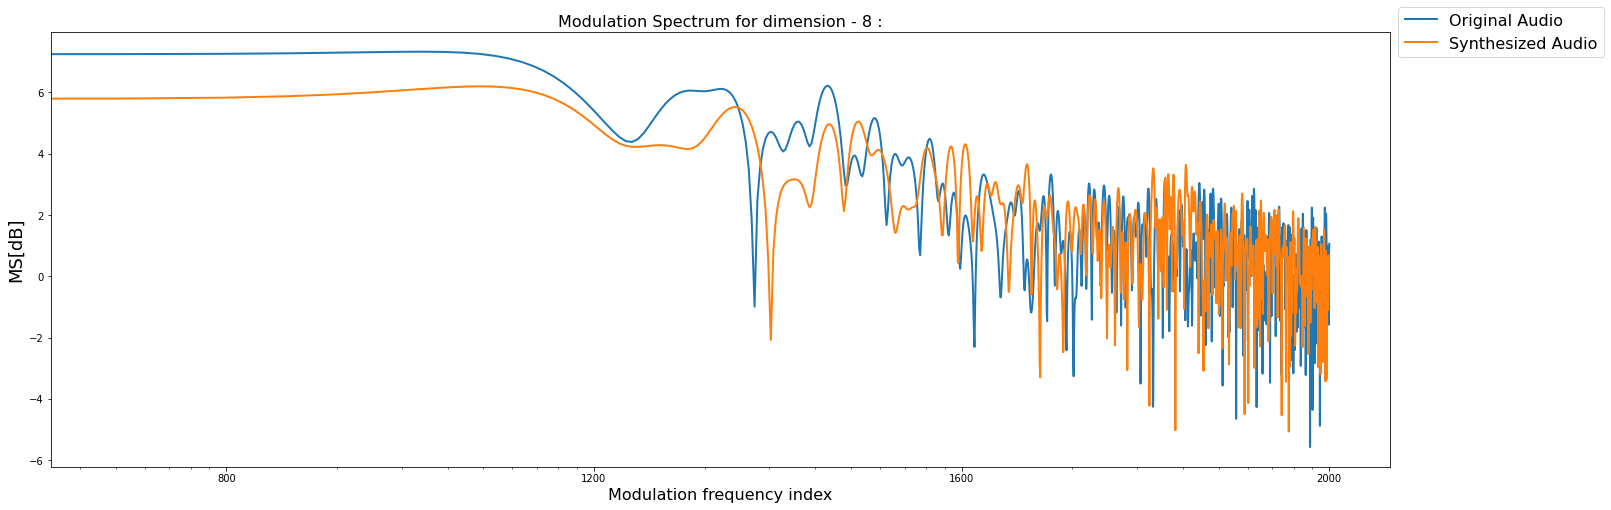

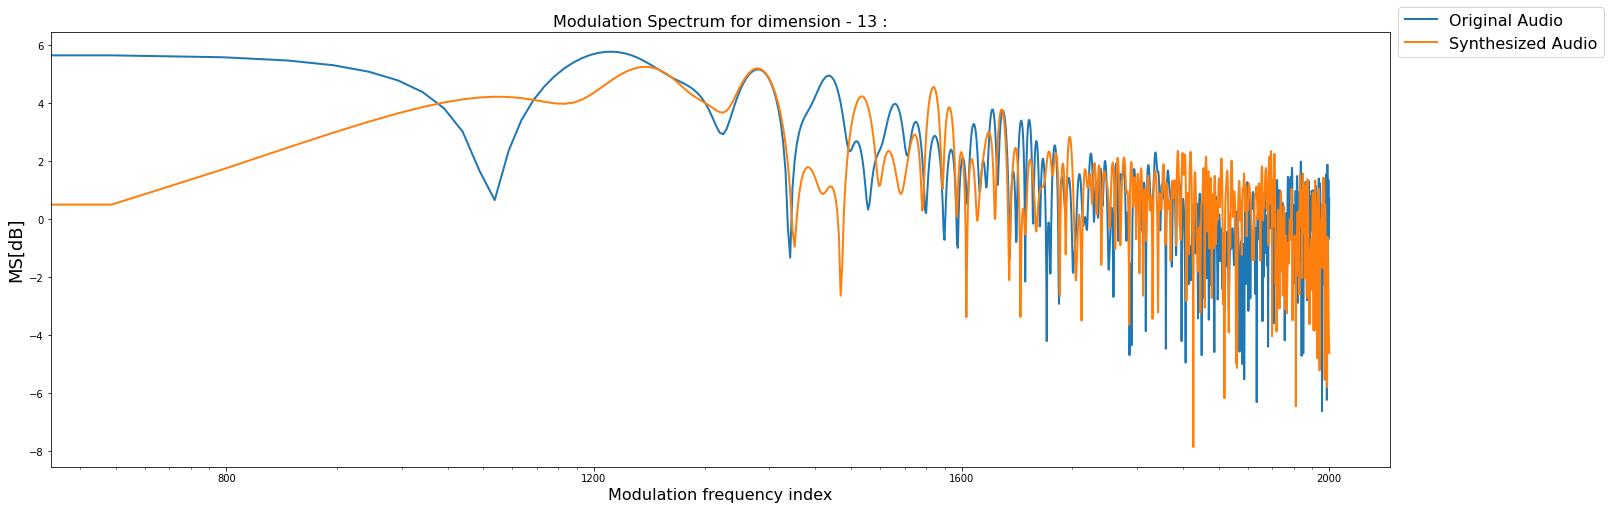

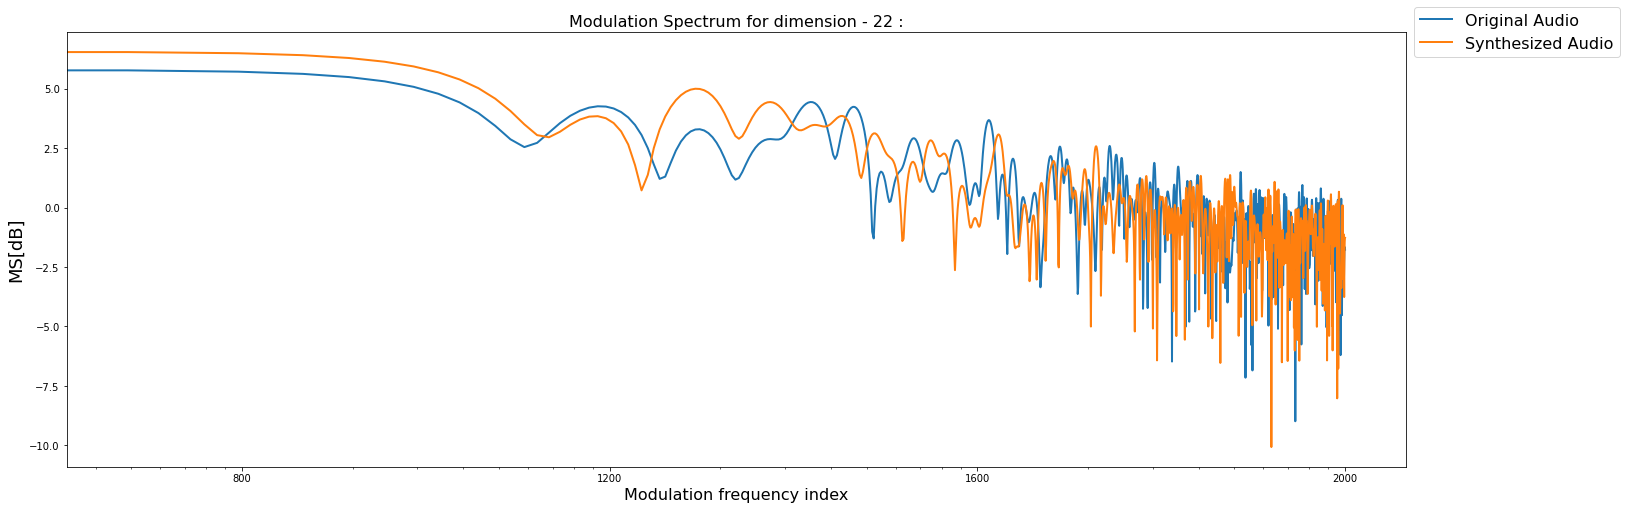

In [ ]:
vis(lists,labels,ind,ms_freq.tolist(),dims)